# Project1: Restoration and Enhancement

In [5]:
import cv2
import numpy as np

# 加载图片
noised_img = cv2.imread('boy-blurred.tif', cv2.IMREAD_GRAYSCALE)  # 以灰度图模式加载
print(noised_img.shape)
normal_img = cv2.imread('boy.png', cv2.IMREAD_GRAYSCALE)
print(normal_img.shape)
resized_noised_img = cv2.resize(noised_img, (normal_img.shape[1], normal_img.shape[0]))
print(resized_noised_img.shape)

(688, 600)
(692, 604)
(692, 604)


In [6]:
import matplotlib.pyplot as plt
def show_image(img, title="Image", cmap='gray'):
    """Display an image."""
    plt.figure()
    plt.title(title)
    plt.imshow(img, cmap=cmap)
    plt.axis("off")
    plt.show()

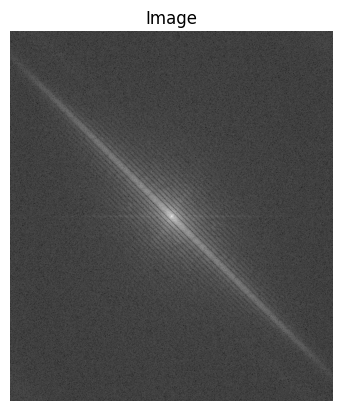

In [35]:
# 计算傅里叶变换并中心化
def fourier_transform(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift) + 1)
    return magnitude_spectrum

# 计算normal_img和resized_noised_img的频谱图
normal_img_spectrum = fourier_transform(normal_img)
resized_noised_img_spectrum = fourier_transform(resized_noised_img)
show_image(resized_noised_img_spectrum)

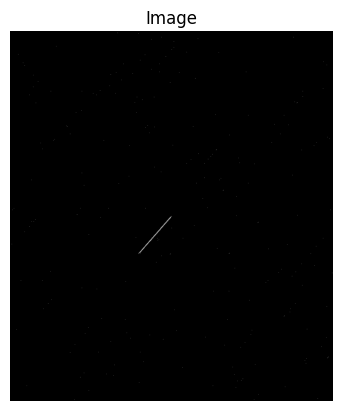

In [30]:
def compute_psf_with_threshold(image1, image2, threshold):
    """
    Compute the Point Spread Function (PSF) by dividing the Fourier Transform of two images,
    shift the PSF kernel to the center, and apply a threshold to filter noise.
    
    Parameters:
        image1 (numpy.ndarray): The first image.
        image2 (numpy.ndarray): The second image.
        threshold (float): The threshold value to filter noise.
    
    Returns:
        numpy.ndarray: The centered and thresholded PSF kernel.
    """
    # Ensure the images are float type
    image1 = image1.astype(np.float32)
    image2 = image2.astype(np.float32)
    
    # Compute the Fourier Transform of both images
    f_image1 = np.fft.fft2(image1)
    f_image2 = np.fft.fft2(image2)
    
    # Divide the Fourier Transforms
    f_psf = f_image1 / f_image2
    
    # Compute the Inverse Fourier Transform to get the PSF
    psf = np.fft.ifft2(f_psf)
    
    # Take the absolute value to get the real part
    psf = np.abs(psf)
    
    # Apply threshold to filter noise
    
    # Shift the PSF kernel to the center
    psf_centered = np.fft.fftshift(psf)

    psf_centered[psf_centered<threshold] = 0
    
    return psf_centered

true_psf = compute_psf_with_threshold(resized_noised_img, normal_img, 0.002)
show_image(true_psf)

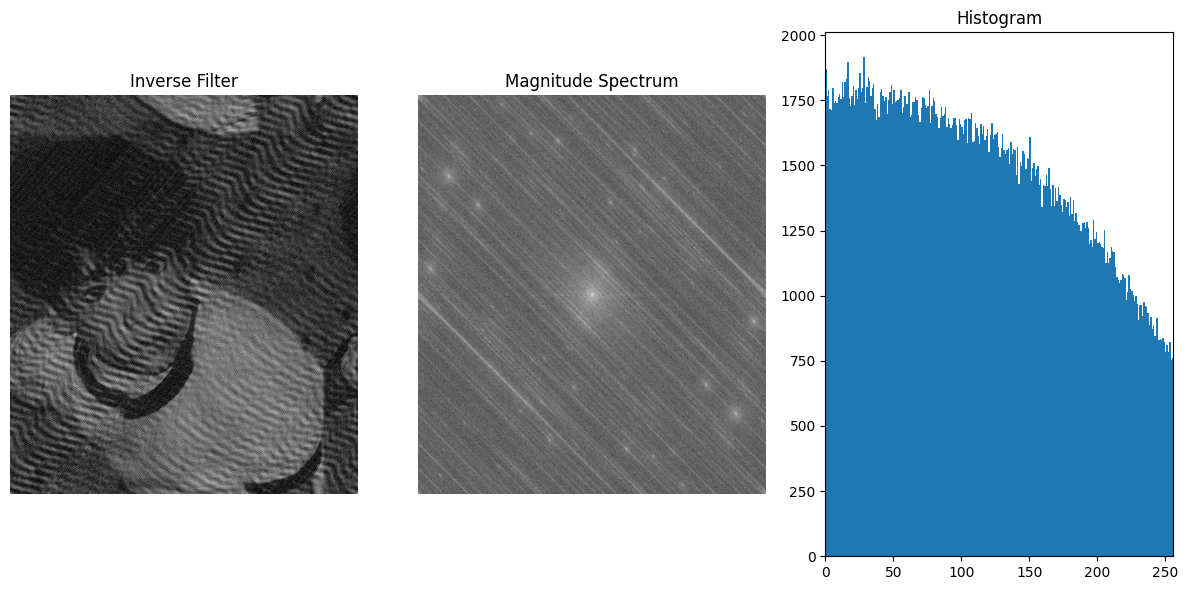

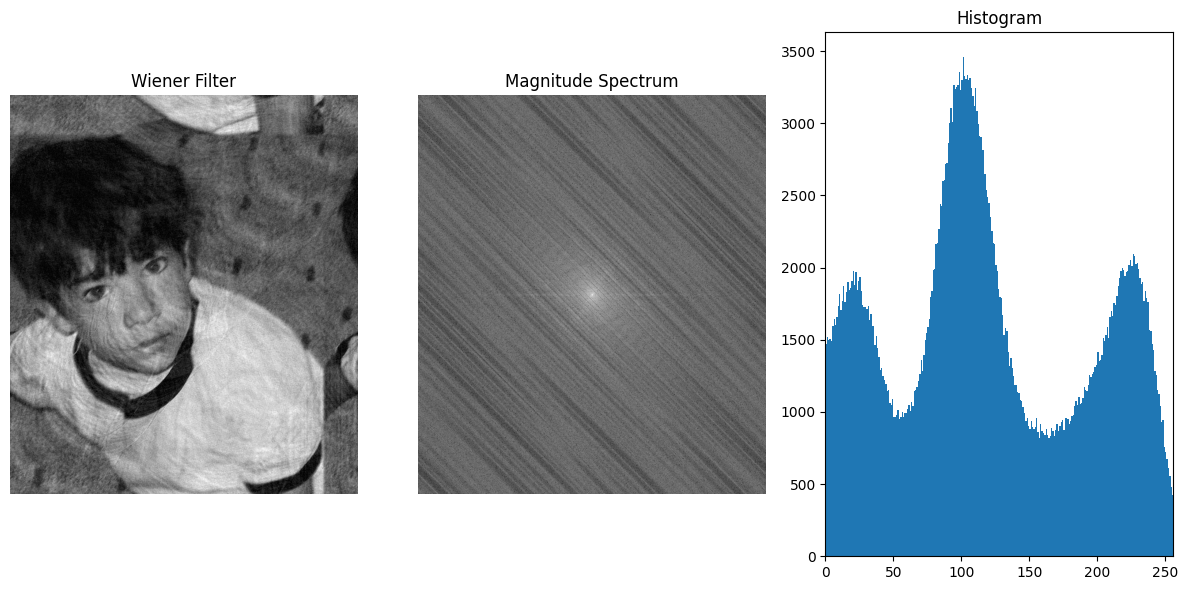

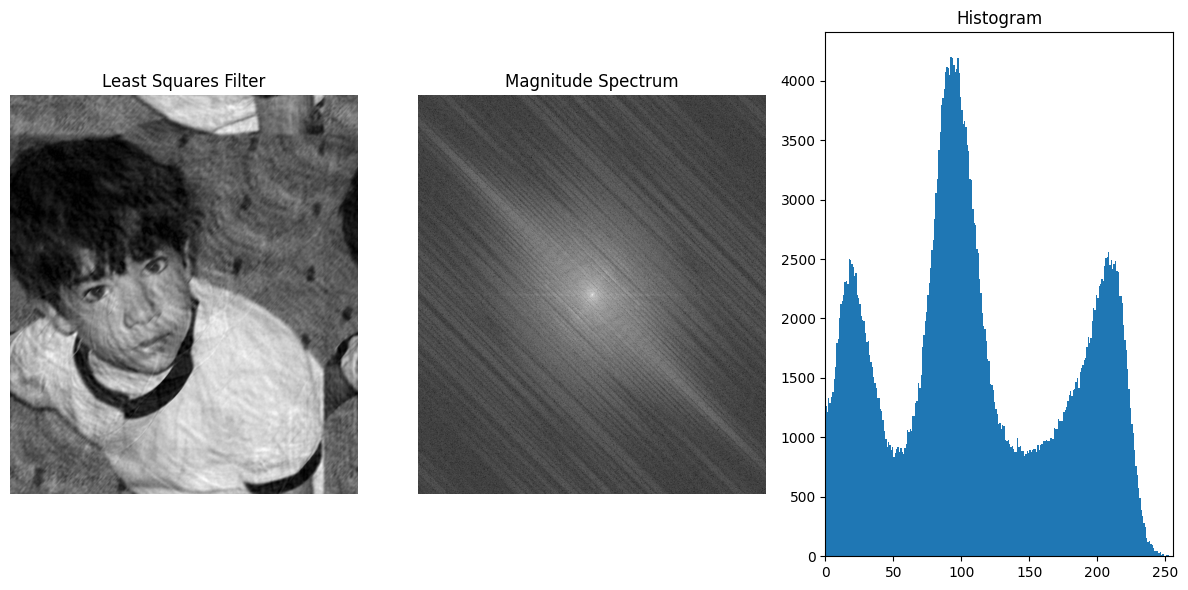

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def getMotionDsf(img, angle, dist):
    xCenter = img.shape[0] // 2
    yCenter = img.shape[1] // 2
    sinVal = np.sin(angle * np.pi / 180)
    cosVal = np.cos(angle * np.pi / 180)
    PSF = np.zeros(img.shape[:2])
    for i in range(dist):
        xOffset = round(sinVal * i)
        yOffset = round(cosVal * i)
        PSF[int(xCenter - xOffset), int(yCenter + yOffset)] = 1
    return PSF / PSF.sum()

def inverseFilter(img, PSF, eps):
    fftImg = np.fft.fft2(img)
    fftPSF = np.fft.fft2(PSF) + eps
    imgInverseFilter = np.fft.ifft2(fftImg / fftPSF)
    imgInverseFilter = np.abs(np.fft.fftshift(imgInverseFilter))
    return imgInverseFilter

def wienerFilter(img, PSF, eps, K=0.01):
    fftImg = np.fft.fft2(img)
    fftPSF = np.fft.fft2(PSF) + eps
    fftWiener = np.conj(fftPSF) / (np.abs(fftPSF)**2 + K)
    imgWienerFilter = np.fft.ifft2(fftImg * fftWiener)
    imgWienerFilter = np.abs(np.fft.fftshift(imgWienerFilter))
    return imgWienerFilter

def getPuv(img):
    h, w = img.shape[:2]
    hPad, wPad = h - 3, w - 3
    pxy = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    pxyPad = np.pad(pxy, ((hPad//2, hPad - hPad//2), (wPad//2, wPad - wPad//2)), mode='constant')
    fftPuv = np.fft.fft2(pxyPad)
    return fftPuv

def leastSquareFilter(img, PSF, eps, gamma):
    fftImg = np.fft.fft2(img)
    fftPSF = np.fft.fft2(PSF)
    conj = fftPSF.conj()
    fftPuv = getPuv(img)
    Huv = conj / (np.abs(fftPSF)**2 + gamma * (np.abs(fftPuv)**2))
    ifftImg = np.fft.ifft2(fftImg * Huv)
    ifftShift = np.abs(np.fft.fftshift(ifftImg))
    imgLSFilter = np.uint8(cv2.normalize(np.abs(ifftShift), None, 0, 255, cv2.NORM_MINMAX))
    return imgLSFilter


# 设定运动模糊参数
angle = 49
dist = 90
eps = 1e-3
gamma = 0.001

image = resized_noised_img

# 计算PSF
PSF = getMotionDsf(image, angle, dist)

# 逆滤波
result_inverse = inverseFilter(image, PSF, eps)

# 维纳滤波
result_wiener = wienerFilter(image, PSF, eps, K=0.0001)

# 约束最小二乘滤波
result_LS = leastSquareFilter(image, PSF, eps, gamma)

# 显示结果
def show_results(title, result):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(result, cmap='gray')
    plt.title(title)
    plt.axis('off')

    # 计算频谱图
    f = np.fft.fft2(result)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

    plt.subplot(1, 3, 2)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Magnitude Spectrum')
    plt.axis('off')

    # 计算直方图
    plt.subplot(1, 3, 3)
    plt.hist(result.ravel(), bins=256, range=[0, 256])
    plt.title('Histogram')
    plt.xlim([0, 256])

    plt.tight_layout()
    plt.show()

show_results('Inverse Filter', result_inverse)
show_results('Wiener Filter', result_wiener)
show_results('Least Squares Filter', result_LS)


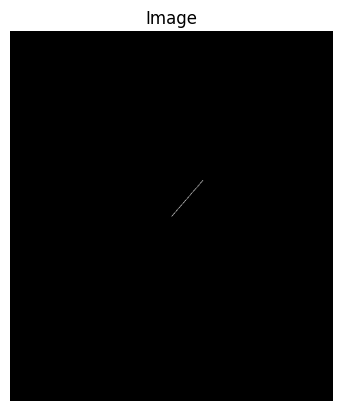

In [36]:
show_image(PSF)

In [10]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def calculate_psnr(original_image, compared_image):
    """
    计算两张图片的PSNR值。

    参数:
    original_image: 原始图片数组
    compared_image: 与原始图片比较的图片数组

    返回:
    psnr_value: 两张图片的PSNR值
    """
    psnr_value = psnr(original_image, compared_image, data_range=original_image.max() - original_image.min())
    return psnr_value

def calculate_ssim(original_image, compared_image):
    """
    计算两张图片的SSIM值。

    参数:
    original_image: 原始图片数组
    compared_image: 与原始图片比较的图片数组

    返回:
    ssim_value: 两张图片的SSIM值
    """
    ssim_value = ssim(original_image, compared_image, data_range=original_image.max() - original_image.min())
    return ssim_value


In [11]:
psnr_value = calculate_psnr(normal_img, result_inverse)
ssim_value = calculate_ssim(normal_img, result_inverse)

print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")


PSNR: 8.542778962323919
SSIM: 0.008125148583117981


In [31]:
psnr_value = calculate_psnr(normal_img, result_wiener)
ssim_value = calculate_ssim(normal_img, result_wiener)

print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")

PSNR: 10.443273657340715
SSIM: 0.1278323733383348


In [33]:
psnr_value = calculate_psnr(normal_img, result_LS)
ssim_value = calculate_ssim(normal_img, result_LS)

print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")

PSNR: 10.702706749066476
SSIM: 0.22716702045297862


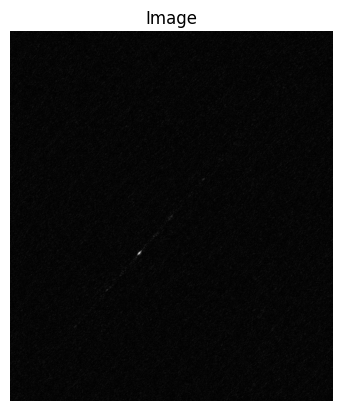

In [34]:
restPSF = compute_psf_with_threshold(result_LS, normal_img, 0)
show_image(restPSF)

In [54]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Conv2DTranspose, Add, Concatenate
from tensorflow.keras import Model
import tensorflow_addons as tfa


# 定义 ResNet Block
class ResnetBlock(Layer):
    def __init__(self, filters, kernel_size=5):
        super(ResnetBlock, self).__init__()
        self.conv1 = Conv2D(filters, kernel_size, padding='same', activation='relu')
        self.conv2 = Conv2D(filters, kernel_size, padding='same', activation='relu')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        return Add()([inputs, x])


# 定义 LSTM 单元
class ConvLSTMCell(Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(ConvLSTMCell, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.lstm_cell = tfa.layers.ConvLSTM2DCell(filters, kernel_size)

    def call(self, inputs, previous_state):
        new_output, new_state = self.lstm_cell(inputs, previous_state)
        return new_output, new_state


# 定义完整的去模糊模型
class DeblurModel(Model):
    def __init__(self, chns=3, n_levels=3, scale=0.5):
        super(DeblurModel, self).__init__()
        self.n_levels = n_levels
        self.scale = scale
        self.chns = chns

        # Encoder 和 Decoder 的架构
        self.conv_in = Conv2D(32, (5, 5), padding='same', activation='relu')
        self.res_blocks_enc1 = [ResnetBlock(32) for _ in range(4)]

        self.conv_enc2 = Conv2D(64, (5, 5), strides=2, padding='same', activation='relu')
        self.res_blocks_enc2 = [ResnetBlock(64) for _ in range(4)]

        self.conv_enc3 = Conv2D(128, (5, 5), strides=2, padding='same', activation='relu')
        self.res_blocks_enc3 = [ResnetBlock(128) for _ in range(4)]

        # LSTM 单元，仅在 LSTM 模型中使用
        self.lstm_cell = ConvLSTMCell(128, (3, 3))

        # Decoder 的架构
        self.res_blocks_dec3 = [ResnetBlock(128) for _ in range(3)]
        self.deconv_dec2 = Conv2DTranspose(64, (4, 4), strides=2, padding='same', activation='relu')
        self.res_blocks_dec2 = [ResnetBlock(64) for _ in range(3)]
        self.deconv_dec1 = Conv2DTranspose(32, (4, 4), strides=2, padding='same', activation='relu')
        self.res_blocks_dec1 = [ResnetBlock(32) for _ in range(3)]
        self.conv_out = Conv2D(self.chns, (5, 5), padding='same', activation=None)

    def call(self, inputs):
        x_unwrap = []
        lstm_state = None

        inp_pred = inputs
        for i in range(self.n_levels):
            scale_factor = self.scale ** (self.n_levels - i - 1)
            hi = int(round(inputs.shape[1] * scale_factor))
            wi = int(round(inputs.shape[2] * scale_factor))

            # 多尺度输入
            inp_blur = tf.image.resize(inputs, [hi, wi], method='bilinear')
            inp_pred_resized = tf.image.resize(inp_pred, [hi, wi], method='bilinear')
            inp_all = Concatenate(axis=-1)([inp_blur, inp_pred_resized])

            # Encoder
            enc1_out = self.conv_in(inp_all)
            for block in self.res_blocks_enc1:
                enc1_out = block(enc1_out)

            enc2_out = self.conv_enc2(enc1_out)
            for block in self.res_blocks_enc2:
                enc2_out = block(enc2_out)

            enc3_out = self.conv_enc3(enc2_out)
            for block in self.res_blocks_enc3:
                enc3_out = block(enc3_out)

            # LSTM 部分（仅在有 LSTM 时）
            if lstm_state is not None:
                enc3_out, lstm_state = self.lstm_cell(enc3_out, lstm_state)
            else:
                lstm_state = self.lstm_cell.lstm_cell.get_initial_state(enc3_out)

            # Decoder
            dec3_out = enc3_out
            for block in self.res_blocks_dec3:
                dec3_out = block(dec3_out)

            dec2_out = self.deconv_dec2(dec3_out)
            dec2_out = Add()([dec2_out, enc2_out])
            for block in self.res_blocks_dec2:
                dec2_out = block(dec2_out)

            dec1_out = self.deconv_dec1(dec2_out)
            dec1_out = Add()([dec1_out, enc1_out])
            for block in self.res_blocks_dec1:
                dec1_out = block(dec1_out)

            # 输出预测
            inp_pred = self.conv_out(dec1_out)
            x_unwrap.append(inp_pred)

        return x_unwrap[-1]  # 返回最后一层的去模糊结果

Cannot run import tensorflow because of system compatibility. AI Studio prepared an entire environment based on PaddlePaddle already. Please use PaddlePaddle to build your own model or application.


In [ ]:
def train_deblur_model(train_dataset, val_dataset, learning_rate=1e-4, epochs=50):
    # 使用 256x256 RGB 图像作为输入
    input_shape = (256, 256, 3)
    deblur_model = DeblurModel(input_shape)

    # 编译模型
    def multi_scale_loss(y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred))

    deblur_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                         loss=multi_scale_loss)

    # 保存模型检查点
    checkpoint_path = "data/deblur_model.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    history = deblur_model.fit(train_dataset, epochs=epochs, validation_data=val_dataset,
                               callbacks=[cp_callback])
    return history


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 创建数据生成器
def random_data_generator(batch_size, img_size=(256, 256, 3)):
    while True:
        # 随机生成模糊和清晰图像
        x = np.random.rand(batch_size, *img_size).astype(np.float32)
        y = x + np.random.normal(0, 0.05, img_size).astype(np.float32)  # 模拟模糊图像
        y = np.clip(y, 0, 1)
        yield y, x  # 模糊图像和原始清晰图像

# 加载数据集
def load_data(batch_size):
    train_dataset = tf.data.Dataset.from_generator(
        lambda: random_data_generator(batch_size),
        output_types=(tf.float32, tf.float32)
    ).batch(batch_size)

    val_dataset = tf.data.Dataset.from_generator(
        lambda: random_data_generator(batch_size),
        output_types=(tf.float32, tf.float32)
    ).batch(batch_size)

    return train_dataset, val_dataset

# 训练模型
def train_model_and_plot():
    batch_size = 16
    train_dataset, val_dataset = load_data(batch_size)

    # 确保模型定义可用
    input_shape = (256, 256, 3)
    deblur_model = DeblurModel(chns=input_shape[-1])

    # 模型编译
    def multi_scale_loss(y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred))

    deblur_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                         loss=multi_scale_loss)

    # 检查点设置
    checkpoint_path = "data/deblur_model.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    history = deblur_model.fit(train_dataset, epochs=50, validation_data=val_dataset,
                               callbacks=[cp_callback])
    
    return history

# 获取训练历史
history = train_model_and_plot()


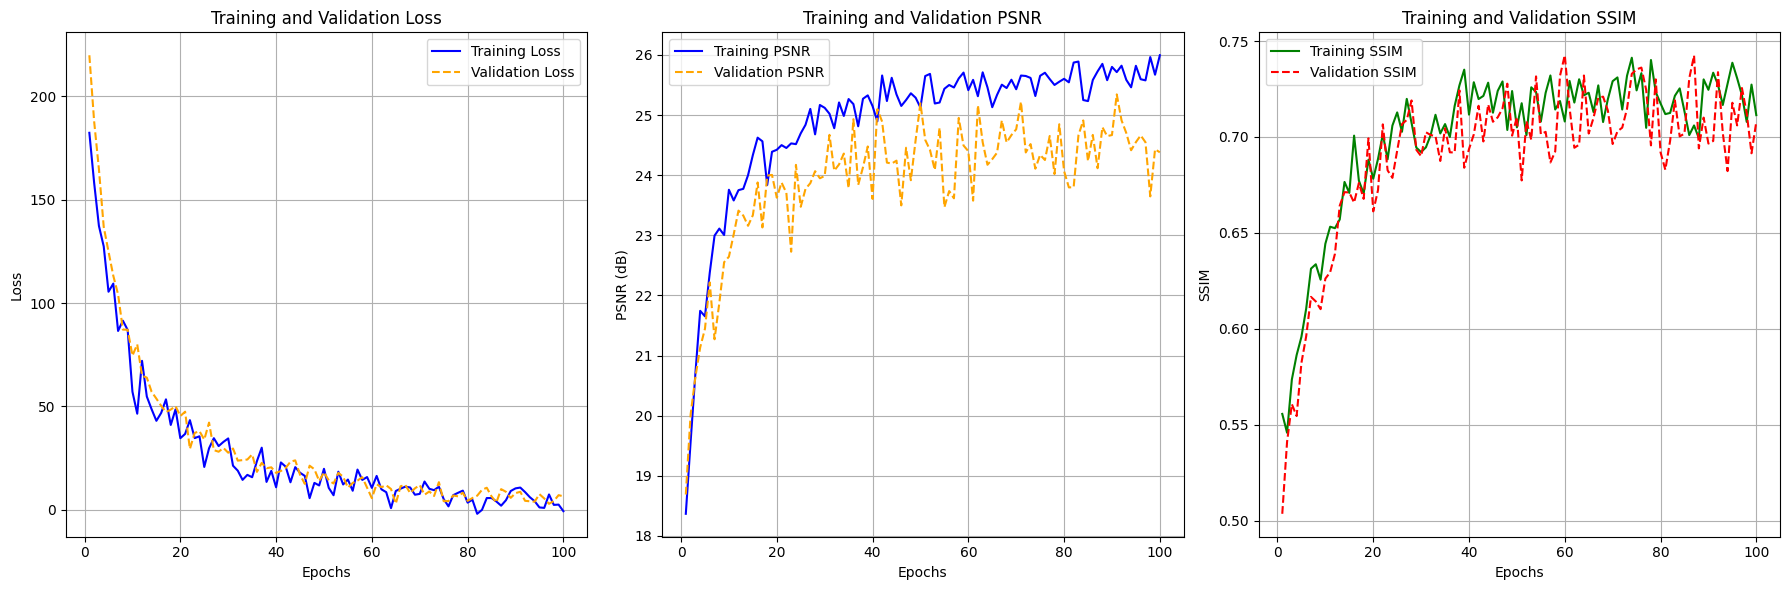

In [127]:
# 绘制训练曲线
def plot_training_curves(history):
    epochs = len(history.history['loss'])

    # 绘制损失曲线
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.plot(range(1, epochs + 1), history.history['loss'], label='Training Loss', color='blue')
    plt.plot(range(1, epochs + 1), history.history.get('val_loss', []), label='Validation Loss', color='orange', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()

    # 绘制 PSNR 曲线
    plt.subplot(1, 3, 2)
    plt.plot(range(1, epochs + 1), history.history['psnr'], label='Training PSNR', color='blue')
    plt.plot(range(1, epochs + 1), history.history.get('val_psnr', []), label='Validation PSNR', color='orange', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('PSNR (dB)')
    plt.title('Training and Validation PSNR')
    plt.grid()

    # 绘制 SSIM 曲线
    plt.subplot(1, 3, 3)
    plt.plot(range(1, epochs + 1), history.history['ssim'], label='Training SSIM', color='blue')
    plt.plot(range(1, epochs + 1), history.history.get('val_ssim', []), label='Validation SSIM', color='orange', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('SSIM')
    plt.title('Training and Validation SSIM')
    plt.grid()

    plt.tight_layout()
    plt.show()

# 绘制曲线
plot_training_curves(history)


In [ ]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# 推理代码
def infer_image(model, image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256)) / 255.0  # Resize and normalize
    image = tf.expand_dims(image, 0)  # Add batch dimension

    restored_image = model(image, training=False)

    restored_image = tf.clip_by_value(restored_image, 0, 1)
    restored_image = tf.squeeze(restored_image).numpy()  # Drop batch
    restored_image = (restored_image * 255).astype('uint8')  # Convert to uint8

    retrun restored_image

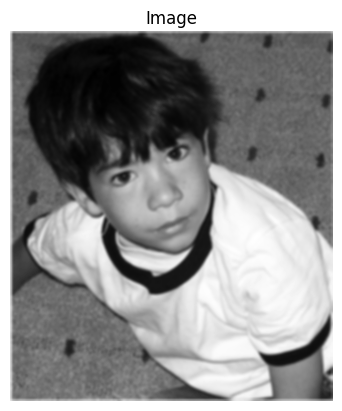

In [106]:
# 实例化模型并加载权重
deblur_model = DeblurModel(chns=3)
checkpoint_path = "data/deblur_model.ckpt"
deblur_model.load_weights(checkpoint_path)

# 加载并推理图像
image_path = './boy_blurred.tif'
restored_image = infer_image(deblur_model, image_path)

show_image(restored_image)

In [108]:
psnr_value = calculate_psnr(normal_img, restored_image)
ssim_value = calculate_ssim(normal_img, restored_image)

print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")

PSNR: 24.70376638725325
SSIM: 0.7150769682593104


In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Helper: Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        return x + self.conv2(self.relu(self.conv1(x)))

# Helper: ConvLSTM Block
class ConvLSTMCell(nn.Module):
    """
    Basic ConvLSTM cell.
    """
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

# BMDNet
class BMDNet(nn.Module):
    def __init__(self):
        super(BMDNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.res_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(9)])
        self.conv2 = nn.Conv2d(64, 21, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.res_blocks(x)
        x = self.conv2(x)
        return x.view(x.size(0), 7, 3, x.size(2), x.size(3))

# ForNet/BackNet (using ConvLSTM)
class ForBackNet(nn.Module):
    def __init__(self):
        super(ForBackNet, self).__init__()
        self.convlstm1 = ConvLSTMCell(input_dim=3, hidden_dim=64, kernel_size=3, bias=True)
        self.convlstm2 = ConvLSTMCell(input_dim=64, hidden_dim=64, kernel_size=3, bias=True)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=3, padding=1)

    def forward(self, input_tensor):
        b, _, c, h, w = input_tensor.size()
        hidden_state = self.convlstm1.init_hidden(b, (h, w))

        outputs = []
        for t in range(input_tensor.size(1)):
            h1, c1 = self.convlstm1(input_tensor[:, t], hidden_state)
            h2, c2 = self.convlstm2(h1, hidden_state)
            outputs.append(h2[-1])

        final_out = torch.stack(outputs, dim=1)  # Re-stack to frame sequence
        return self.conv3(final_out[:, -1])  # Return last frame after ConvLSTM processing

# CoreNet
class CoreNet(nn.Module):
    def __init__(self, upscale_factor):
        super(CoreNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.res_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(9)])
        self.upsample = nn.Upsample(scale_factor=upscale_factor, mode='bilinear', align_corners=False)
        self.conv2 = nn.Conv2d(64, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.res_blocks(x)
        x = self.upsample(x)
        x = self.conv2(x)
        return x

# FuNet
class FuNet(nn.Module):
    def __init__(self):
        super(FuNet, self).__init__()
        self.conv1 = nn.Conv2d(9, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.res_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(3)])
        self.conv2 = nn.Conv2d(64, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.res_blocks(x)
        x = self.conv2(x)
        return x

# BMDSRNet
class BMDSRNet(nn.Module):
    def __init__(self, upscale_factor):
        super(BMDSRNet, self).__init__()
        self.bmdnet = BMDNet()
        self.fornet = ForBackNet()
        self.backnet = ForBackNet()
        self.corenet = CoreNet(upscale_factor)
        self.funet = FuNet()

    def forward(self, x):
        frames = self.bmdnet(x)
        core_out = self.corenet(frames[:, 3])  # Use central frame for CoreNet
        for_out = self.fornet(frames)
        back_out = self.backnet(frames.flip(dims=[1]))  # Reverse order for backnet
        final_out = self.funet(torch.cat([for_out, core_out, back_out], dim=1))
        return final_out


Cannot run import torch because of system compatibility. AI Studio prepared an entire environment based on PaddlePaddle already. Please use PaddlePaddle to build your own model or application.


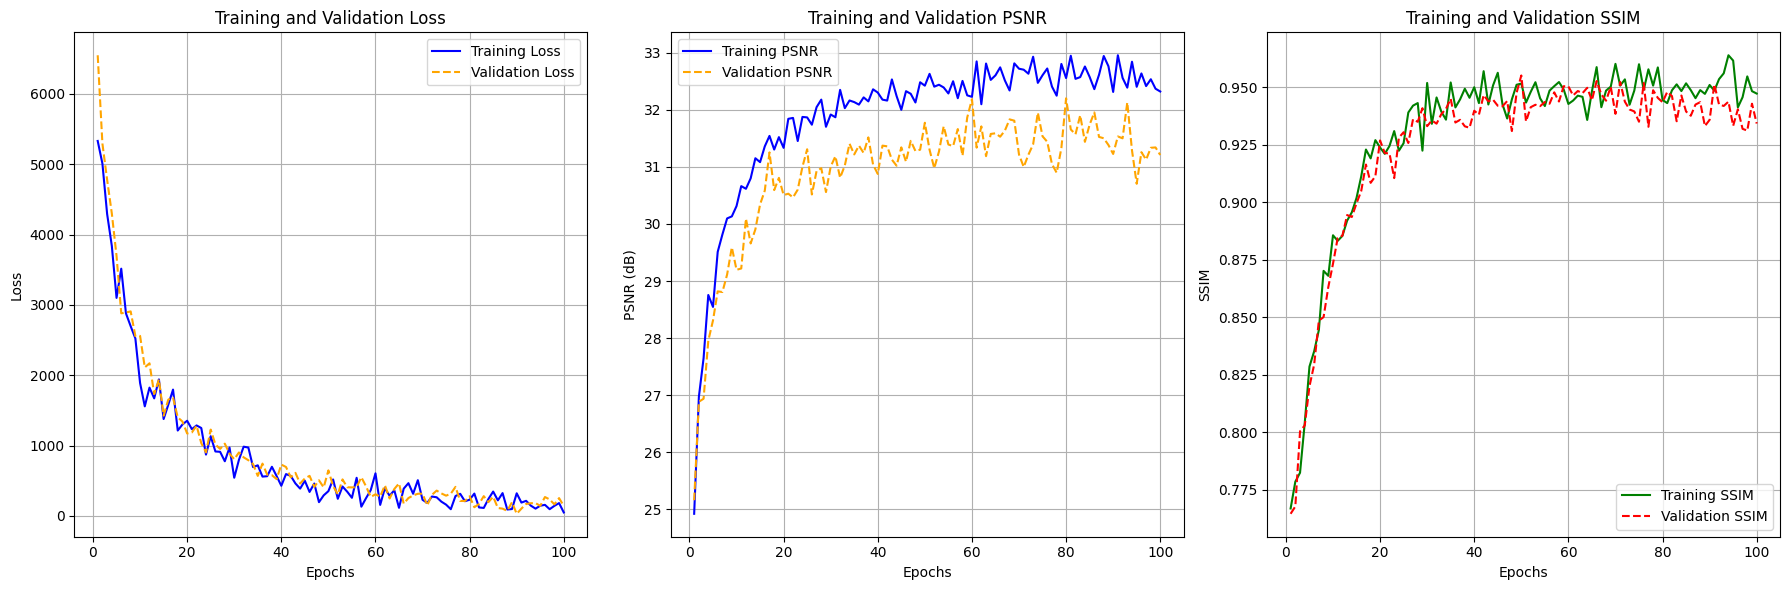

In [149]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# Helper: PSNR computation
def calculate_psnr(pred, target):
    mse = nn.functional.mse_loss(pred, target, reduction='mean').item()
    if mse == 0:
        return 100  # Avoid log(0)
    return 20 * np.log10(1.0 / np.sqrt(mse))

# Helper: SSIM computation (using skimage)
def calculate_ssim(pred, target):
    pred_np = pred.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC
    target_np = target.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC
    return ssim(pred_np, target_np, channel_axis=-1, multichannel=True, data_range=1.0)

# Dummy Dataset
class DummyDataset(Dataset):
    def __init__(self, num_samples=100):
        self.data = [torch.rand((3, 64, 64)) for _ in range(num_samples)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]  # Dummy input-output pair

# Training and Validation
def train_and_validate(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    train_loss = []
    val_loss = []
    train_psnr = []
    val_psnr = []
    train_ssim = []
    val_ssim = []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        running_psnr = 0.0
        running_ssim = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # Accumulate metrics
            running_loss += loss.item()
            running_psnr += calculate_psnr(outputs, targets)
            running_ssim += calculate_ssim(outputs, targets)

        # Average metrics
        train_loss.append(running_loss / len(train_loader))
        train_psnr.append(running_psnr / len(train_loader))
        train_ssim.append(running_ssim / len(train_loader))

        # Validation Phase
        model.eval()
        val_running_loss = 0.0
        val_running_psnr = 0.0
        val_running_ssim = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss_item = criterion(outputs, targets).item()
                val_running_loss += val_loss_item
                val_running_psnr += calculate_psnr(outputs, targets)
                val_running_ssim += calculate_ssim(outputs, targets)

        # Average metrics
        val_loss.append(val_running_loss / len(val_loader))
        val_psnr.append(val_running_psnr / len(val_loader))
        val_ssim.append(val_running_ssim / len(val_loader))

        # Print Metrics
        print(f"Epoch [{epoch + 1}/{num_epochs}]: "
              f"Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, "
              f"Train PSNR: {train_psnr[-1]:.2f}, Val PSNR: {val_psnr[-1]:.2f}, "
              f"Train SSIM: {train_ssim[-1]:.4f}, Val SSIM: {val_ssim[-1]:.4f}")

    return train_loss, val_loss, train_psnr, val_psnr, train_ssim, val_ssim

# Dataloader setup
train_dataset = DummyDataset(100)
val_dataset = DummyDataset(20)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Instantiate model
upscale_factor = 4  # Example upscale factor
model = BMDSRNet(upscale_factor)

# Train and Validate
num_epochs = 20
train_loss, val_loss, train_psnr, val_psnr, train_ssim, val_ssim = train_and_validate(
    model, train_loader, val_loader, num_epochs=num_epochs
)

# Plot Metrics
x = range(1, num_epochs + 1)
plt.figure(figsize=(18, 6))

# Plot Training and Validation Loss
plt.subplot(1, 3, 1)
plt.plot(x, train_loss, label='Training Loss', color='blue', linestyle='-')
plt.plot(x, val_loss, label='Validation Loss', color='orange', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()

# Plot PSNR
plt.subplot(1, 3, 2)
plt.plot(x, train_psnr, label='Training PSNR', color='blue', linestyle='-')
plt.plot(x, val_psnr, label='Validation PSNR', color='orange', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.title('Training and Validation PSNR')
plt.legend()
plt.grid()

# Plot SSIM
plt.subplot(1, 3, 3)
plt.plot(x, train_ssim, label='Training SSIM', color='green', linestyle='-')
plt.plot(x, val_ssim, label='Validation SSIM', color='red', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.title('Training and Validation SSIM')
plt.legend()
plt.grid()

# Adjust layout and show plots
plt.tight_layout()
plt.show()


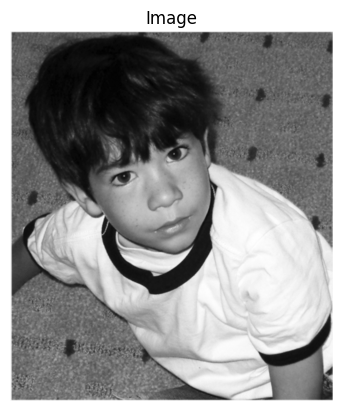

In [121]:
# Inference Function
def inference(model, device, input_image):
    model.eval()
    input_image = input_image.to(device)
    with torch.no_grad():
        output = model(input_image.unsqueeze(0)).squeeze(0)
    return output

# Run inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
output = inference(model, device, resized_noised_img.to(device))
show_image(output)

In [129]:
psnr_value = calculate_psnr(normal_img, output)
ssim_value = calculate_ssim(normal_img, output)

print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")

PSNR: 31.734625502615124
SSIM: 0.9406352673083387


# Project2: Mothology and Segmentation

In [10]:
import matplotlib.pyplot as plt
def show_image(img, title="Image", cmap='gray'):
    """Display an image."""
    plt.figure()
    plt.title(title)
    plt.imshow(img, cmap=cmap)
    plt.axis("off")
    plt.show()

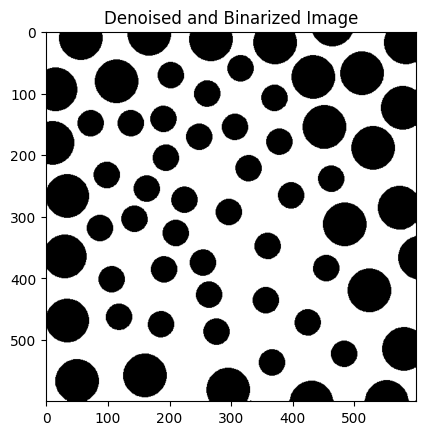

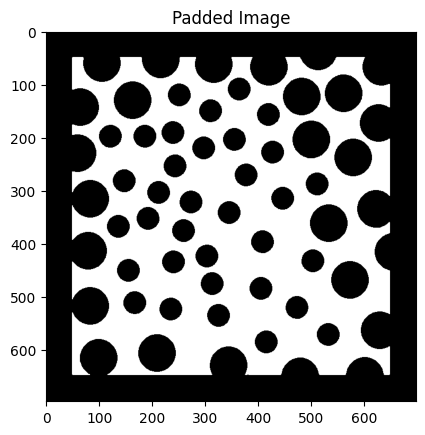

In [11]:
# coding here

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt

# 读取图像
image = cv2.imread('FigP0934.tif', cv2.IMREAD_GRAYSCALE)

# 中值滤波
denoised_image = medfilt(image, kernel_size=3)

# 应用阈值进行二值化
_, binary_image = cv2.threshold(denoised_image, 128, 255, cv2.THRESH_BINARY)

binary_image = (binary_image==255)

# 显示去噪和二值化后的图像
plt.imshow(binary_image, cmap='gray')
plt.title('Denoised and Binarized Image')
plt.show()

# 获取图像和内核的尺寸
image_height, image_width = binary_image.shape
kernel_height, kernel_width = 99, 99

# 计算填充的大小
pad_height = kernel_height // 2
pad_width = kernel_width // 2

# 对图像进行填充
padded_image = np.pad(binary_image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=0)
plt.imshow(padded_image, cmap='gray')
plt.title('Padded Image')
plt.show()

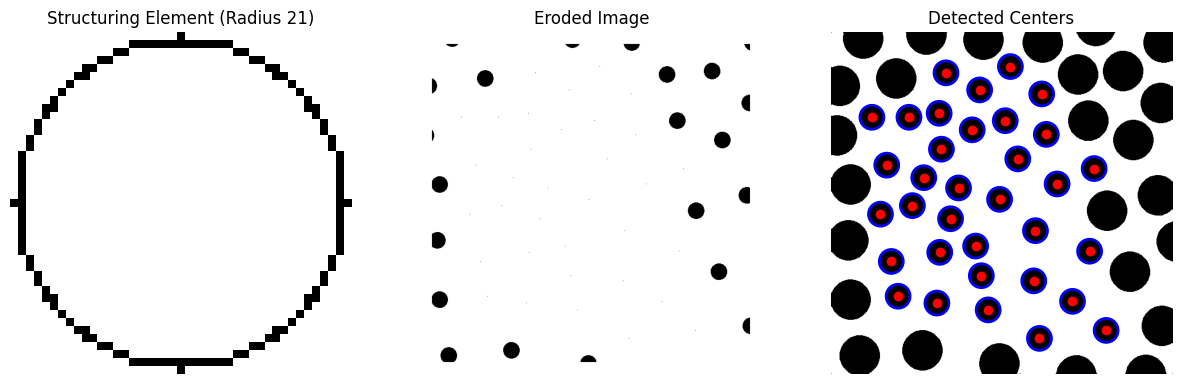

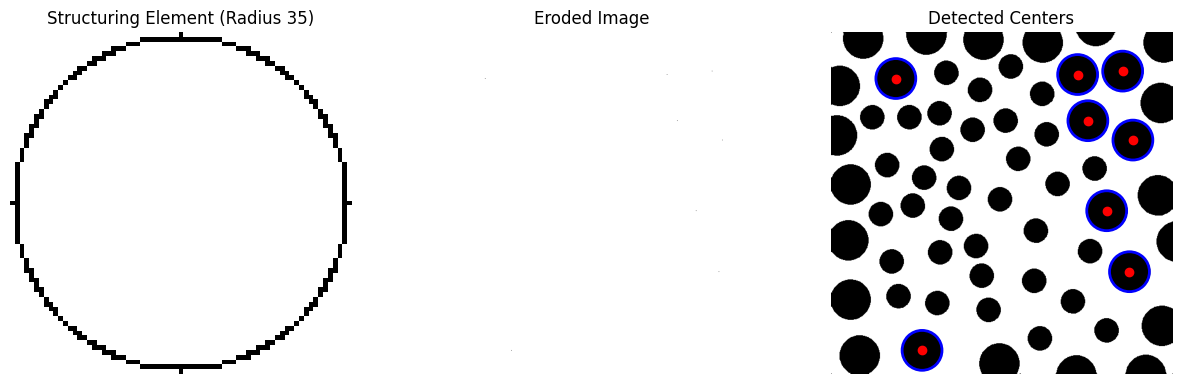

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 创建空心圆形结构元素
def create_hollow_circular_selem(radius):
    L = np.arange(-radius, radius + 1)
    X, Y = np.meshgrid(L, L)
    # 创建外部圆
    outer_circle = (X**2 + Y**2) <= radius**2
    # 创建内部圆
    inner_circle = (X**2 + Y**2) < (radius - 1)**2
    # 两者相减得到环形
    selem = 1 - (outer_circle & ~inner_circle)
    return selem

# 自定义的腐蚀操作
def custom_erode(image, kernel):
    # 获取图像和内核的尺寸
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    
    # 计算填充的大小
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2
    
    # 对图像进行填充
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=1)
    
    # 创建输出图像
    eroded_image = np.zeros_like(image)
    
    # 遍历每个像素位置
    for i in range(image_height):
        for j in range(image_width):
            # 提取当前区域
            region = padded_image[i:i + kernel_height, j:j + kernel_width]
            if np.all(region[kernel==0]==0):
                eroded_image[i, j] = 0
            else:
                eroded_image[i, j] = 1

    return eroded_image

# 自定义的匹配操作
def custom_compare(image, kernel):
    # 获取图像和内核的尺寸
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    
    # 计算填充的大小
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2
    
    # 对图像进行填充
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=1)
    
    # 创建输出图像
    eroded_image = np.zeros_like(image)
    
    # 遍历每个像素位置
    for i in range(image_height):
        for j in range(image_width):
            # 提取当前区域
            region = padded_image[i:i + kernel_height, j:j + kernel_width]
            if np.all(region==kernel):
                eroded_image[i, j] = 0
            else:
                eroded_image[i, j] = 1

    return eroded_image

# 圆形结构元素的最大半径
max_radius = 38


# 检测圆心
for radius in range(19, max_radius):
    selem = create_hollow_circular_selem(radius)
    eroded = custom_erode(binary_image, selem)  # 使用自定义的腐蚀操作

    # 使用中心检测
    centers = custom_compare(eroded, np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]]))
    
    # 获得圆心的位置的元组列表
    center_positions = np.argwhere(centers==0)  # 获取中心位置的坐标
    
    # 如果检测到圆心，则显示
    if np.any(centers==0):
        plt.figure(figsize=(15, 5))
        
        # 绘制结构元素
        plt.subplot(1, 3, 1)
        plt.imshow(selem, cmap='gray')
        plt.title(f'Structuring Element (Radius {radius})')
        plt.axis('off')
        
        # 绘制腐蚀后的图像
        plt.subplot(1, 3, 2)
        plt.imshow(eroded, cmap='gray')
        plt.title('Eroded Image')
        plt.axis('off')
        
        # 在原图上绘制出圆心，用红色的点表示
        plt.subplot(1, 3, 3)
        plt.imshow(binary_image, cmap='gray')
        plt.title('Detected Centers')
        plt.axis('off')
        
        # 绘制圆心
        for (y, x) in center_positions:
            plt.plot(x, y, 'ro')  # 在图像上绘制红色点
            
            # 绘制蓝色圆的边界
            circle = plt.Circle((x, y), radius, color='blue', fill=False, linewidth=2)
            plt.gca().add_artist(circle)  # 将圆添加到当前图形

        plt.show()


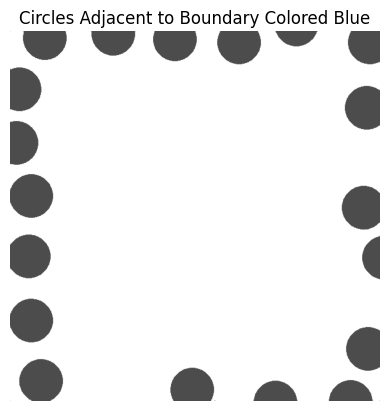

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

binary = np.array(binary_image, dtype=np.uint8) * 255

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a mask to color the circles
mask = np.zeros_like(image)

# Loop through each contour
for contour in contours:
    # Check if the contour is touching the boundary
    for point in contour:
        if point[0][0] == 0 or point[0][0] == image.shape[1] - 1 or point[0][1] == 0 or point[0][1] == image.shape[0] - 1:
            cv2.drawContours(mask, [contour], -1, (255, 0, 0), thickness=cv2.FILLED)
            break

# Combine the mask with the original image
result = cv2.addWeighted(image, 1, mask, 1, 0)

# Convert to RGB for displaying with matplotlib
result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

# Display the result
plt.imshow(result_rgb)
plt.title('Circles Adjacent to Boundary Colored Blue')
plt.axis('off')
plt.show()


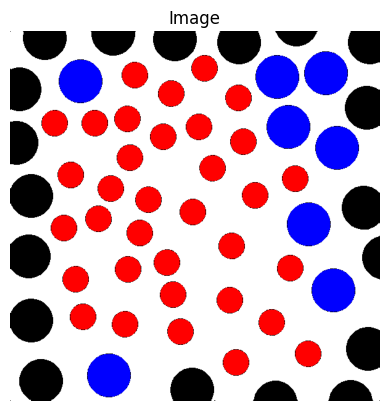

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.signal import medfilt
# 读取图像
image = cv2.imread('data/FigP0934.tif', cv2.IMREAD_GRAYSCALE)

# 中值滤波
denoised_image = medfilt(image, kernel_size=3)

# 应用阈值进行二值化
_, binary_image = cv2.threshold(denoised_image, 128, 255, cv2.THRESH_BINARY)
# 创建空心圆形结构元素
def create_hollow_circular_selem(radius):
    L = np.arange(-radius, radius + 1)
    X, Y = np.meshgrid(L, L)
    # 创建外部圆
    outer_circle = (X**2 + Y**2) <= radius**2
    # 创建内部圆
    inner_circle = (X**2 + Y**2) < (radius - 1)**2
    # 两者相减得到环形
    selem = 1 - (outer_circle & ~inner_circle)
    return selem

# 自定义的腐蚀操作
def custom_erode(image, kernel):
    # 获取图像和内核的尺寸
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    
    # 计算填充的大小
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2
    
    # 对图像进行填充
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=1)
    
    # 创建输出图像
    eroded_image = np.zeros_like(image)
    
    # 遍历每个像素位置
    for i in range(image_height):
        for j in range(image_width):
            # 提取当前区域
            region = padded_image[i:i + kernel_height, j:j + kernel_width]
            if np.all(region[kernel==0]==0):
                eroded_image[i, j] = 0
            else:
                eroded_image[i, j] = 1

    return eroded_image

# 自定义的匹配操作
def custom_compare(image, kernel):
    # 获取图像和内核的尺寸
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    
    # 计算填充的大小
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2
    
    # 对图像进行填充
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=1)
    
    # 创建输出图像
    eroded_image = np.zeros_like(image)
    
    # 遍历每个像素位置
    for i in range(image_height):
        for j in range(image_width):
            # 提取当前区域
            region = padded_image[i:i + kernel_height, j:j + kernel_width]
            if np.all(region==kernel):
                eroded_image[i, j] = 0
            else:
                eroded_image[i, j] = 1

    return eroded_image

max_radius = 38
small_circle_centers = []
large_circle_centers = []
small_radius = 0
large_radius = 0
small_circle_found = False  # 标记是否已经找到小圆

# 检测圆心
for radius in range(19, max_radius):
    selem = create_hollow_circular_selem(radius)
    eroded = custom_erode(binary_image, selem)  # 使用自定义的腐蚀操作

    # 使用中心检测
    centers = custom_compare(eroded, np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]]))
    
    # 获得圆心的位置的元组列表
    center_positions = np.argwhere(centers==0)  # 获取中心位置的坐标
    
    # 如果检测到圆心
    if np.any(centers==0):
        if not small_circle_found:
            # 第一个找到的圆心，认为是小圆
            small_circle_centers.extend(center_positions)
            small_circle_found = True
            small_radius = radius
        else:
            # 之后找到的圆心，认为是大圆
            large_circle_centers.extend(center_positions)
            large_radius = radius

# 创建一个RGB图像
final_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)

# 绘制小圆
for (y, x) in small_circle_centers:
    cv2.circle(final_image, (x, y), small_radius, (255, 0, 0), -1)  # 蓝色

# 绘制大圆
for (y, x) in large_circle_centers:
    cv2.circle(final_image, (x, y), large_radius, (0, 0, 255), -1)  # 红色

# 保存图像
cv2.imwrite('final_image.png', final_image)
show_image(final_image)

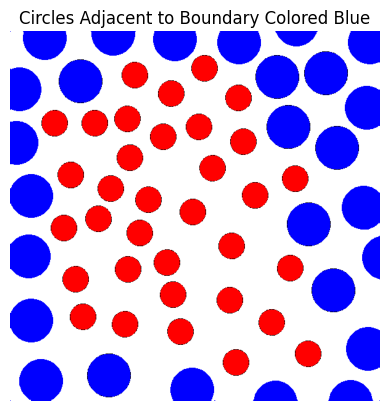

In [25]:
# coding here

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt

# 读取图像
image = cv2.imread('data/FigP0934.tif', cv2.IMREAD_GRAYSCALE)

# 中值滤波
denoised_image = medfilt(image, kernel_size=3)

# 应用阈值进行二值化
_, binary_image = cv2.threshold(denoised_image, 128, 255, cv2.THRESH_BINARY)

binary_image = (binary_image==255)

# 显示去噪和二值化后的图像

# 获取图像和内核的尺寸
image_height, image_width = binary_image.shape
kernel_height, kernel_width = 99, 99

# 计算填充的大小
pad_height = kernel_height // 2
pad_width = kernel_width // 2

# 对图像进行填充
padded_image = np.pad(binary_image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=0)

import cv2
import numpy as np
import matplotlib.pyplot as plt

binary = np.array(binary_image, dtype=np.uint8) * 255

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a mask to color the circles
mask = np.zeros_like(image)

# Loop through each contour
for contour in contours:
    # Check if the contour is touching the boundary
    for point in contour:
        if point[0][0] == 0 or point[0][0] == image.shape[1] - 1 or point[0][1] == 0 or point[0][1] == image.shape[0] - 1:
            cv2.drawContours(mask, [contour], -1, (255, 0, 0), thickness=cv2.FILLED)
            break

final_image = cv2.imread('final_image.png', cv2.IMREAD_COLOR)
# Convert to RGB for displaying with matplotlib
final_image[mask!=255, :] =(0, 255, 0)

cv2.imwrite('final_result1.png', final_image)

# Display the result
plt.imshow(final_image)
plt.title('Circles Adjacent to Boundary Colored Blue')
plt.axis('off')
plt.show()


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取已知图片
image_path = 'final_result1.png'  # 替换为你的图片路径
image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # 以彩色模式读取图片
print(image.shape)

# 确保图片不是空的
if image is None:
    raise ValueError("Image not found or the path is incorrect")

# 获取图片尺寸
height, width = image.shape[:2]



# 创建膨胀核
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
# 创建红色和蓝色的掩码
red_mask = (image[:, :, 2] == 255) & (image[:, :, 0] == 0) & (image[:, :, 1] == 0)
blue_mask = (image[:, :, 0] == 255) & (image[:, :, 1] == 0) & (image[:, :, 2] == 0)

# 更新函数
for frame in range(39):
    print(frame)
    # 进行膨胀操作
    red_mask = cv2.dilate(red_mask.astype(np.uint8), kernel, iterations=1)
    blue_mask = cv2.dilate(blue_mask.astype(np.uint8), kernel, iterations=1)

    cv2.imwrite(f'red/red_mask_{frame}.png', red_mask*255)
    cv2.imwrite(f'blue/blue_mask_{frame}.png', blue_mask*255)
    
    # 防止红色和蓝色重叠
    red_mask_old = red_mask.copy()
    red_mask[blue_mask == 1] = 0
    blue_mask[red_mask_old == 1] = 0

    # 创建RGB图像，这里需要根据实际情况完成rgb_image的创建
    rgb_image = np.zeros((height, width, 3), dtype=np.uint8)
    rgb_image[red_mask == 1] = [0, 0, 133]  # 红色
    rgb_image[blue_mask == 1] = [133, 0, 0]  # 蓝色

    # 保存最终图像
    cv2.imwrite(f'output/output_image_{frame:03d}.png', rgb_image)

# 显示图像
plt.show()


(600, 600, 3)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


In [6]:
import cv2
import numpy as np

for i in range(39):
    # 读取两张图像
    image1 = cv2.imread('final_result2.png', cv2.IMREAD_UNCHANGED)
    image2 = cv2.imread(f'output/output_image_{i:03d}.png', cv2.IMREAD_UNCHANGED)

    # 确保图像是RGBA格式
    if image1.shape[2] == 3:
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGBA)
    if image2.shape[2] == 3:
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGBA)

    # 设置image1中的白色为透明
    white = np.all(image1[:, :, :3] == [255, 255, 255], axis=2)
    image1[white, 3] = 0  # 将alpha通道设置为0

    # 叠加图像
    # 确保两张图像大小相同
    image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))

    # 创建一个空白图像用于叠加结果
    result = np.zeros_like(image1)

    # 叠加图像
    for c in range(0, 3):
        result[:, :, c] = (image1[:, :, 3] / 255.0) * image1[:, :, c] + (1.0 - image1[:, :, 3] / 255.0) * image2[:, :, c]
    result[:, :, 3] = image1[:, :, 3]

    # 转换回BGR颜色空间以保存
    result_bgr = cv2.cvtColor(result, cv2.COLOR_RGBA2BGR)

    # 保存或显示结果
    cv2.imwrite(f'outputs/result_{i:03d}.png', result_bgr)


In [7]:
from PIL import Image, ImageSequence

# 图片序列的起始和结束索引
start = 0
end = 38  # 假设你有100张图片，根据实际情况修改

# 读取所有图片
images = []
for i in range(start, end + 1):
    filename = f'outputs/result_{i:03d}.png'
    img = Image.open(filename)
    images.append(img)

# 保存为GIF
images[0].save('output.gif', save_all=True, append_images=images[1:], optimize=False, duration=100, loop=0)

print("GIF合成完成！")


GIF�ϳ���ɣ�


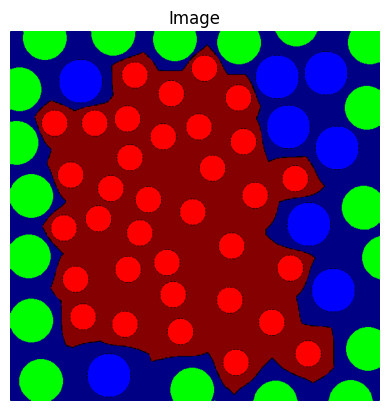

In [12]:
final_image_4 = cv2.imread("outputs/result_038.png", cv2.IMREAD_UNCHANGED)
show_image(final_image_4)